<a href="https://colab.research.google.com/github/KingGuzman/Node-Classifier-Explainer/blob/main/Node_Classifier_Explainer_Mutag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run all the cells one after another

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 9.3 MB/s 
     |████████████████████████████████| 3.5 MB 9.3 MB/s 


In [2]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import torch_geometric as torch_geometric
import math

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, DataLoader

import torch_geometric.transforms as T

#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv,GINConv
from torch.distributions import Bernoulli,Categorical

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import random
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

import math

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import time
from datetime import datetime
import torch.optim as optim
import numpy as np
import matplotlib.colors as colors


from torch_geometric.data import Data, DataLoader

import torch_geometric.transforms as T

#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv,GINConv
from torch.distributions import Bernoulli,Categorical
import matplotlib.cm as cmx


In [4]:
train_mask=random.sample(range(0, 3000), 3000)
test_mask=random.sample(range(3001,3371),370)

In [5]:
dataset1=torch_geometric.datasets.TUDataset(root='/tmp/Entities',name="MUTAG")
dataset2=torch_geometric.datasets.TUDataset(root='/tmp/Entities1',name="MUTAG",transform=torch_geometric.transforms.OneHotDegree(4,cat=False))
#dataset1=torch_geometric.datasets.Coauthor(root='/tmp/Coauthor',name="CS")

dir(dataset2)
#print(dataset.url)



Extracting /tmp/Entities/MUTAG/MUTAG.zip
Processing...
Done!
Extracting /tmp/Entities1/MUTAG/MUTAG.zip
Processing...
Done!


['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data_list',
 '_download',
 '_indices',
 '_process',
 'cleaned',
 'cleaned_url',
 'collate',
 'copy',
 'data',
 'download',
 'get',
 'index_select',
 'indices',
 'len',
 'name',
 'num_classes',
 'num_edge_attributes',
 'num_edge_features',
 'num_edge_labels',
 'num_features',
 'num_node_attributes',
 'num_node_features',
 'num_node_labels',
 'pre_filter',
 'pre_transform',
 'process',
 'processed_dir',
 'processed_file_names',
 'processed_paths',
 'raw_dir',
 'raw_file_names',
 'raw_paths',
 'root',
 'shuffle

In [6]:
dat=dataset2.data
print(dat)


print(dat.edge_index.size())

print(dat.y)
x=dat.x
print(x)
print(len(x[0]))
x1=torch.argmax(x,dim=1)

newdatx=x
print(len(newdatx))
print(x1[0:300])


Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
torch.Size([2, 7442])
tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
7
3371
tensor([0, 0, 0, 0

In [ ]:
print(x[0])

tensor([1., 0., 0., 0., 0., 0., 0.])


In [7]:
dat=dataset1.data
print(dat)
#print(dat.y)
x=dat.x
print(x)
print(len(x[0]))
x1=torch.argmax(x,dim=1)
newdatx=x
newdaty=x1
print(x1[0:30])


Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
7
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 2, 2])


In [9]:
#cont=np.loadtxt("/content/MUTAG_A.txt",dtype='str')
with open("/content/MUTAG_A.txt") as infile, open("outfile.txt", "w") as outfile:
    for line in infile:
        outfile.write(line.replace(",", " "))


cont=np.loadtxt("/content/outfile.txt",dtype=int)

cont=cont-1
print(cont)
edgeind=torch.from_numpy(cont)
edgeind=torch.transpose(edgeind,0,1)
edgeind=edgeind.long()

print(len(edgeind[0]))
print(edgeind[0][1:5])

[[   1    0]
 [   0    1]
 [   2    1]
 ...
 [3368 3369]
 [3370 3368]
 [3368 3370]]
7442
tensor([0, 2, 1, 3])


In [10]:
print(edgeind.size())
print(type(edgeind))

torch.Size([2, 7442])
<class 'torch.Tensor'>


In [11]:
newdat=Data(x=newdatx,edge_index=edgeind,y=newdaty)
print(newdat.edge_index[0][1:5])
print(len(newdat.x))
print(len(newdat.y))


newdataset=[]
newdataset.append(newdat)

tensor([0, 2, 1, 3])
3371
3371


In [12]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(3):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
            self.lns.append(nn.LayerNorm(hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)
        reward=F.softmax(x,dim=1)
        

        return emb,reward,F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)
        #F.nll_loss(pred, label)

In [13]:
def train(dataset, task):
    torch.manual_seed(2)
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
         loader = DataLoader(dataset, batch_size=1, shuffle=True)

    # build model
    model = GNNStack(max(num_node_features, 1), 64, 7, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model=model.to(device)
    
    # train
    for epoch in range(250):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            batch=batch.to(device)
            embedding,reward,pred = model(batch)
            
            label = batch.y
            #label=label.float()
            #labelonehot=torch.nn.functional.one_hot(label,num_classes=2)
            #labelonehot=labelonehot.float()
            #labelonehot=torch.zeros_like(label)
            #labelonehot=labelonehot.scatter(1,label, 1)
            #pred = pred[batch.train_mask]
            #label = label[batch.train_mask]
            
            loss = model.loss(pred[train_mask], label[train_mask])
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        #writer.add_scalar("loss", total_loss, epoch)

        if epoch % 20 == 0:
          print(epoch)
          #print(reward)
          print(loss*100)
          #print(pred.shape)
            #test_acc = test(test_loader, model)
            #print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                #epoch, total_loss, test_acc))
            #writer.add_scalar("test accuracy", test_acc, epoch)

    return model

In [14]:
def test(loader, model, task='node'):
    model.eval()

    correct = 0
    total=0
    for data in loader:
        with torch.no_grad():
            emb, reward,pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y
            

        #if task == 'node':
            #mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            #pred = pred[mask]
            #label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
        total+=len(label)
    
    #if task == 'graph':
     #   total = len(loader.dataset) 
    #else:
        #total = len(loader.dataset)*50
        
    return correct / total,total,correct

In [15]:
print(newdataset)

[Data(x=[3371, 7], edge_index=[2, 7442], y=[3371])]


Code for finding nodes of any label you want to. Not necessary to run

In [ ]:
laba=newdataset[0]

laba1=laba.y.tolist()
print(laba1)
f=[]
for i in range(len(laba1)):
  if (laba1[i]==1):
    f.append(i)
print(f)



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 3, 1, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Node Classifier Training Code

In [16]:
task = 'node'
num_node_features=7

model = train(newdataset, task)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


0
tensor(184.7082, grad_fn=<MulBackward0>)
20
tensor(14.3967, grad_fn=<MulBackward0>)
40
tensor(7.6119, grad_fn=<MulBackward0>)
60
tensor(5.7904, grad_fn=<MulBackward0>)
80
tensor(4.8927, grad_fn=<MulBackward0>)
100
tensor(4.4260, grad_fn=<MulBackward0>)
120
tensor(4.2981, grad_fn=<MulBackward0>)
140
tensor(3.4687, grad_fn=<MulBackward0>)
160
tensor(3.3538, grad_fn=<MulBackward0>)
180
tensor(2.8423, grad_fn=<MulBackward0>)
200
tensor(2.1948, grad_fn=<MulBackward0>)
220
tensor(2.6317, grad_fn=<MulBackward0>)
240
tensor(1.9734, grad_fn=<MulBackward0>)


In [17]:
embedding,reward,pred = model(newdat)
pred=pred.argmax(dim=1)
label=newdat.y
correct=pred[test_mask].eq(label[test_mask]).sum().item()
total=len(label[test_mask])
accuracy=correct/total
print(accuracy)
print(total)

0.9756756756756757
370


In [18]:
class GCNPolicy(torch.nn.Module):
  def __init__(self):
    super(GCNPolicy, self).__init__()
    self.conv1=GCNConv(num_gennode_features,num_hidden_features)
    self.conv2=GCNConv(num_hidden_features,num_hidden_features)
    self.conv3=GCNConv(num_hidden_features,num_gennode_features)
    self.lin1=nn.Sequential(nn.Linear((num_gennodes)*num_gennode_features, num_hidden_features),nn.ReLU(),nn.Linear(num_hidden_features,num_hidden_features),nn.ReLU(),nn.Linear(num_hidden_features,num_gennodes-1))
  def forward(self,gendata):
        x, edge_index = gendata.x, gendata.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x=F.relu(x)
        x=self.conv3(x,edge_index)
        x=F.relu(x)
        x=torch.flatten(x)
        x=self.lin1(x)
        x=F.softmax(x/temp)
        #x=Bernoulli(x)
        #action=x.sample()
       
        return x

Defining colormap before plotting

In [19]:

cmap = colors.ListedColormap(['blue', 'black','red','yellow','orange','green','purple'])
ColorLegend = {'Carbon': 0,'Nitrogen': 1,'Oxygen': 2,'Fluorine': 3,'Iodine':4,'Chlorine':5,'Bromine':6}
cNorm  = colors.Normalize(vmin=0, vmax=6)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(cmap.colors)

['blue', 'black', 'red', 'yellow', 'orange', 'green', 'purple']


Generating Templates and Query nodes 





tensor([2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053])
tensor([7])
tensor([[ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  5,  0,  6,  5,  7,  6,  8,  2,
          9,  8, 10,  8],
        [ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  0,  5,  5,  6,  6,  7,  2,  8,
          8,  9,  8, 10]])
torch.Size([11, 7])
tensor([0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2])
tensor([2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053])
tensor([[ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  5,  0,  6,  5,  7,  6,  8,  2,
          9,  8, 10,  8],
        [ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  0,  5,  5,  6,  6,  7,  2,  8,
          8,  9,  8, 10]])
tensor([0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2])
tensor([0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2])
tensor([476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
        490, 491, 492])
tensor([16])
tensor([[ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  5,  0,  6,  5,  7,  6,  8,  6,
          9,  3, 10,  9, 11, 10, 11,  2, 12, 11, 13, 12, 14, 13, 1

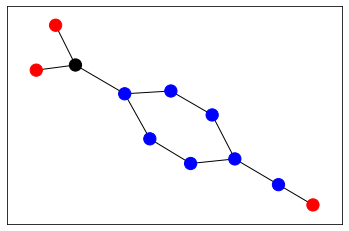

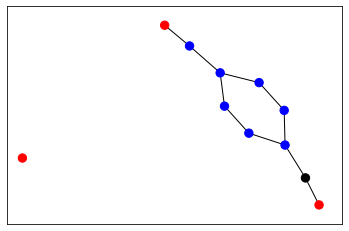

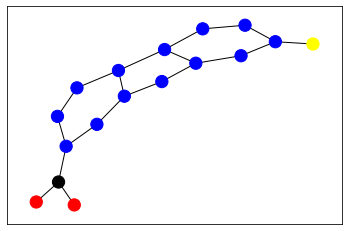

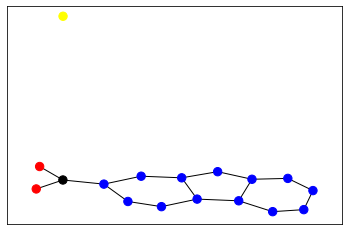

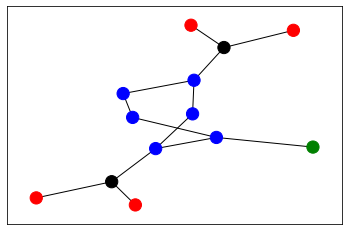

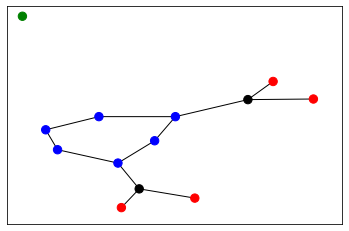

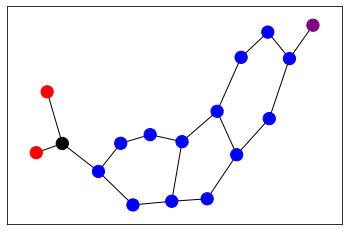

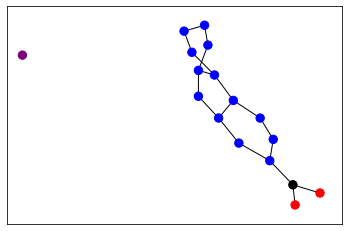

In [27]:
nodeid=[2050,492,452,728]
graphlist=[]
lisdataset=[]
classid=[]
for ind in range(len(nodeid)):
  keepnodes=torch.tensor(5)
  subgraphy=torch.tensor(5)
  subgraphx=torch.tensor(5)
  newfeatures=torch.tensor(5)
  newy=torch.tensor(5)
  count=0
  count1=0
  subgraphind=[]
  edgeind=newdat.edge_index

  subgraph=pyg_utils.k_hop_subgraph(nodeid[ind],16,edgeind,relabel_nodes=False)
  subgraph1=pyg_utils.k_hop_subgraph(nodeid[ind],16,edgeind,relabel_nodes=True)
  if count==0:
    keepnodes=subgraph[0]
    count=1
  else:

    keepnodes=torch.cat([keepnodes,subgraph[0]],dim=0)
  print(subgraph[0])

  #print(len(subgraph[0]))

  print(subgraph[2])
  x=newdat.x
  y=newdat.y
  #print(y)
  features=[x[i] for i in subgraph[0]]
  features=torch.stack(features)
  #print(subgraphx)
  subgraphind=subgraph1[1]
  print(subgraphind)
  k=[y[i] for i in subgraph[0]]
  k=torch.stack(k)
  if count1==0:
    subgraphy=k
    subgraphx=features
    count1=1
  else:
    subgraphy=torch.cat([subgraphy,k],dim=0)
    subgraphx=torch.cat([subgraphx,features],dim=0)
    #lis=list(set(list(flatten(L))))
  print(subgraphx.shape)
  print(subgraphy)
  nodelabels=subgraphy
  #print(len(subgraphy))
  newdata=Data(x=subgraphx,edge_index=subgraphind,y=subgraphy)
  G=pyg_utils.to_networkx(newdata)
  v=torch.sort(keepnodes)
  newkeep=v[0]
  x=newdat.x
  y=newdat.y
  #print(y)
  newfeatures=[x[i] for i in newkeep]
  newfeatures=torch.stack(newfeatures)
  newy=[y[i] for i in newkeep]
  newy=torch.stack(newy)


  print(v[0])
  subgraphedge=pyg_utils.subgraph(keepnodes,edgeind,relabel_nodes=True)
  print(subgraphedge[0])
  subgraphdata=Data(x=newfeatures,edge_index=subgraphedge[0],y=newy)
  H=pyg_utils.to_networkx(subgraphdata,to_undirected=True)
  print(subgraphdata.y)

  nodelabels=subgraphdata.y
  print(nodelabels)
  plt.figure(ind+1)
  nx.draw_networkx(H,node_size=150,node_color=nodelabels,cmap=cmap,vmin=0,vmax=6,with_labels=False)
  deletedsubgraphnodes=newkeep[0:len(newkeep)-1]
  deletedsubgraphind1=pyg_utils.subgraph(deletedsubgraphnodes,newdat.edge_index)
  deletedsubgraphind2=pyg_utils.subgraph(deletedsubgraphnodes,deletedsubgraphind1[0],relabel_nodes=True)
  deletedsubgraphdata=Data(x=newfeatures,edge_index=deletedsubgraphind2[0],y=newy)
  L=pyg_utils.to_networkx(deletedsubgraphdata,to_undirected=True)
  nodelabels=deletedsubgraphdata.y
  lisdataset.append(deletedsubgraphdata)
  graphlist.append(L)
  classid.append(nodelabels[-1])
  plt.figure(10*(ind+1))
  nx.draw_networkx(L,node_size=70,node_color=nodelabels,cmap=cmap,vmin=0,vmax=6,with_labels=False)









Checking class labels of query nodes in each template

In [28]:
print(classid)
waok=lisdataset[0]
print(waok)

[tensor(2), tensor(3), tensor(5), tensor(6)]
Data(x=[11, 7], edge_index=[2, 20], y=[11])


In [22]:
def takeFirst(elem):
  return elem[0]

Code for Neigborhood Generator below:-

for loop newdegree counter
0
softmax
tensor([0.0988, 0.0988, 0.0993, 0.1015, 0.1004, 0.1012, 0.0999, 0.1000, 0.0994,
        0.1007], grad_fn=<SoftmaxBackward0>)
explainer output
tensor(9)
for loop newdegree counter
1
softmax
tensor([0.0988, 0.0988, 0.0993, 0.1015, 0.1004, 0.1012, 0.0999, 0.1000, 0.0994,
        0.1007], grad_fn=<SoftmaxBackward0>)
explainer output
tensor(2)
reward
2
reward
2
for loop newdegree counter
0
softmax
tensor([0.0988, 0.0988, 0.0993, 0.1015, 0.1004, 0.1012, 0.0999, 0.1000, 0.0994,
        0.1007], grad_fn=<SoftmaxBackward0>)
explainer output
tensor(6)
for loop newdegree counter
1
softmax
tensor([0.0988, 0.0987, 0.0993, 0.1015, 0.1004, 0.1012, 0.0999, 0.1000, 0.0994,
        0.1007], grad_fn=<SoftmaxBackward0>)
explainer output
tensor(2)
reward
2
reward
2
for loop newdegree counter
0
softmax
tensor([0.0988, 0.0988, 0.0993, 0.1015, 0.1004, 0.1012, 0.0999, 0.1000, 0.0994,
        0.1007], grad_fn=<SoftmaxBackward0>)
explainer output
tensor(1)
for loop newdegree 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
       grad_fn=<SoftmaxBackward0>)
explainer output
tensor(14)
reward
2
reward
2
for loop newdegree counter
0
softmax
tensor([0.0183, 0.1295, 0.0173, 0.0642, 0.0908, 0.0500, 0.0069, 0.0394, 0.0071,
        0.0972, 0.0735, 0.0429, 0.0619, 0.0459, 0.1257, 0.1294],
       grad_fn=<SoftmaxBackward0>)
explainer output
tensor(12)
for loop newdegree counter
1
softmax
tensor([0.0188, 0.1283, 0.0178, 0.0645, 0.0905, 0.0504, 0.0072, 0.0399, 0.0075,
        0.0968, 0.0735, 0.0434, 0.0622, 0.0463, 0.1245, 0.1283],
       grad_fn=<SoftmaxBackward0>)
explainer output
tensor(4)
reward
2
reward
2
for loop newdegree counter
0
softmax
tensor([0.0183, 0.1295, 0.0173, 0.0642, 0.0908, 0.0500, 0.0069, 0.0394, 0.0071,
        0.0972, 0.0735, 0.0429, 0.0619, 0.0459, 0.1257, 0.1294],
       grad_fn=<SoftmaxBackward0>)
explainer output
tensor(9)
for loop newdegree counter
1
softmax
tensor([0.0188, 0.1283, 0.0178, 0.0645, 0.0905, 0.0504, 0.0072, 0.0399, 0.0074,


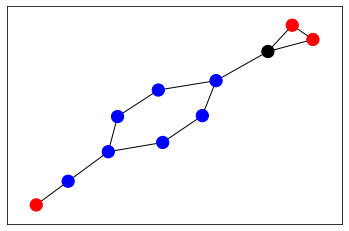

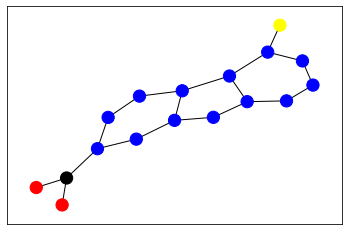

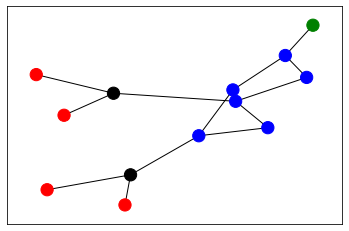

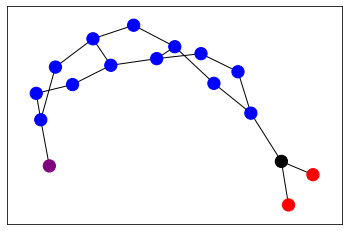

In [29]:

torch.manual_seed(6)
task='node'
#explainer=GCNPolicy(1,32,1,task=task)
temp=10
testdat=[]

discount=1
num_gennode_features=7
num_hidden_features=64
  
#for classes in range(2):
  #model = GNNStack(max(3, 1), 32, 2, task=task)

loss1=nn.BCELoss()
newdegree=2 # This is the Maxdeg parameter
rollout=3
numepisodes=10

for j in range(len(lisdataset)):#len(lisdataset)
  data=lisdataset[j]
  num_gennodes=len(data.y)
  explainer=GCNPolicy()
  opt = torch.optim.Adam(explainer.parameters(), lr=1e-2)
  classes=classid[j]

  #explainer.train()
  
  for epoch in range(30):
      data=lisdataset[j]
      geph=nx.Graph()
      G=nx.Graph()
      geph=graphlist[j]
      G.add_nodes_from(geph)
      G.add_edges_from(geph.edges)
      #newdegree=2
      
      label=data.y
      newmask=torch.ones(num_gennodes-1)
      Actions=[]
      Rewards=[]
      States=[]
      DiscountedReturns=[]

      loss=0
      
      #print(label)
      for episodes in range(numepisodes):
        data=lisdataset[j]
        geph=nx.Graph()
        G=nx.Graph()
        geph=graphlist[j]
        G.add_nodes_from(geph)
        G.add_edges_from(geph.edges)
      #newdegree=2
      
        label=data.y
        Rewards=[]
        newmask=torch.ones(num_gennodes-1)

        for k in range(newdegree):
          #plt.figure()
          #nx.draw_networkx(G, node_size=150,with_labels=True, node_color='pink')
        
          rollmask=torch.ones(num_gennodes-1)
          print("for loop newdegree counter")
          print(k)
          output=explainer(data)
          States.append(data)
          print("softmax")
        
          print(output)
          #o=output.numpy()
          #o=np.multiply(o,newmask)
          #target=output*newmask
          #output=output*newmask
          #print(output)
          m = Categorical(output)
          #print(m)
          action = m.sample()
          print("explainer output")
          print(action)
          Actions.append(action)
          a=action.item()
          #output=output*newmask

          rollmask[a]=0
          G.add_edge(a,num_gennodes-1)
          deg1=G.degree()
          #print("degree of G while entering for loop")
          #print(deg1)
          reward=0
          #for r in range(rollout):
            #V=nx.Graph()
            #V.add_nodes_from(G)
            #V.add_edges_from(G.edges)
            #degroll=V.degree()
            #print("degree of V before rollout")
            #print(degroll)
            #degroll=list(degroll)
            #degroll.sort(key=takeFirst)
            #print(degroll)
            #degroll=[degroll[i][1] for i in range(num_gennodes)]
            #degcounter=degroll[num_gennodes-1]
            #degroll=torch.FloatTensor(degroll)
            #degroll=torch.reshape(deg,(num_gennodes,1))
            #rolldata=pyg_utils.from_networkx(V)
            #rolldata.x=degroll
            #plt.figure()
            #nx.draw_networkx(V, node_size=150,with_labels=True, node_color='white')
          
            #if(k!=newdegree-1):
              #rolloutput=explainer(rolldata)
              #rolloutput=rolloutput*rollmask
              #rollm=Categorical(rolloutput)
              #rollaction=rollm.sample()
              #rollaction=rollaction.item()
              #print("rollout action")
              #print(rollaction)
              #V.add_edge(rollaction,num_gennodes-1)
            #degroll=V.degree()
            #degroll=list(degroll)
            #degroll.sort(key=takeFirst)
            #print("degree of V after rollout")
            #print(degroll)
            #degroll=[degroll[i][1] for i in range(num_gennodes)]
            #degroll=torch.FloatTensor(degroll)
            #degroll=torch.reshape(deg,(num_gennodes,1))
            #rolldata=pyg_utils.from_networkx(V)
            #rolldata.x=degroll
            #rollemb,classifierreward,rollpred=model(rolldata)
            #pred=rollpred.argmax(dim=1)
            #reward+=(classifierreward[num_gennodes-1][classes]-0.5)*100
            #plt.figure()
            #nx.draw_networkx(V, node_size=150,with_labels=True, node_color='yellow')
            #pred.eq(label).sum().item()+
            #pred.eq(label).sum().item()
          #reward=reward/rollout
         
        
          
          
         
          expnewdata=pyg_utils.from_networkx(G)
          expnewdata.x=data.x
          expnewdata.y=data.y
          data=expnewdata
          #print(data.x)
          #if(k!=newdegree-1):
            #reward=0
          #else:
          rollemb,classifierreward,rollpred=model(data)
            #print(classifierreward)
          reward=(classifierreward[num_gennodes-1][classes]-0.5)
         
         
          Rewards.append(reward)
          #emb1,rew1,pred1=model(data)
          #pred=pred1.argmax(dim=1)
          #reward2=(rew1[num_gennodes-1][classes]-0.5)
          #reward2=0
          #pred.eq(label).sum().item()+
          #reward=reward+reward2
          #opt.zero_grad()
          #loss+=-m.log_prob(action)*(reward)
          #if(epoch%10==0):
          #print("loss")
          #print(loss)
     #compute discounted returns
      #DiscountedReturns=[]
        for t in range(len(Rewards)):
          print("reward")
          print(len(Rewards))
          sum=0.0
          for v,r in enumerate(Rewards[t:]):
            sum+=r
          DiscountedReturns.append(sum)
      #print("DiscountedReturns")
      #print(DiscountedReturns)
      print(Rewards)
      #for x in range(1):
        
        #print("enter loss calculation")
        #States=torch.FloatTensor(States)
        #probs=explainer(States)
        #dist=torch.distributions.Categorical(probs=probs)
        #log_prob = dist.log_prob(Actions)
        #loss=-(log_prob*DiscountedReturns).sum()/num_episodes
        #opt.zero_grad()
        #opt.step()


      loss=0
      print("DiscountedReturns")
      print(len(DiscountedReturns))
      DiscountedReturns=torch.tensor(DiscountedReturns)
      DiscountedReturns=(DiscountedReturns-DiscountedReturns.mean())/(DiscountedReturns.std()+1e-9)
      #compute baseline for advantage functions
      b1=0
      b2=0
      ele=0
      ele1=0
      Advantage=[]
      countstep=0
      while(ele<len(DiscountedReturns)):
        if(ele%2==0):
          b1+=DiscountedReturns[ele]
          countstep+=1
        else:
          b2+=DiscountedReturns[ele]
        ele+=1
      b1=b1/countstep
      b2=b2/countstep
      while(ele1<len(DiscountedReturns)):
        if(ele1%2==0):
         Advantage.append(DiscountedReturns[ele1]-b1)
        else:
          Advantage.append(DiscountedReturns[ele1]-b2)
        ele1+=1
      print("Advantage Function")
      print(len(Advantage))

      


      for State, Action, R in zip(States, Actions, DiscountedReturns):
        print("return")
        print(R)
        probs = explainer(State)
        dist = torch.distributions.Categorical(probs=probs)    
        log_prob = dist.log_prob(Action)
        
        loss+= - log_prob*R
        
      newloss=loss/numepisodes
      print("loss")
      print(newloss)
      opt.zero_grad()
      newloss.backward()
      opt.step()

  
  #nx.draw_networkx(G, node_size=150,with_labels=False, node_color=color_map)
  testdat.append(data)
  plt.figure(j)
  nx.draw_networkx(G, node_size=150,node_color=label,cmap=cmap,vmin=0,vmax=6,with_labels=False)

In [30]:
for i in range(len(testdat)):
  rolldata=testdat[i]
  rollemb,classifierreward,rollpred=model(rolldata)
  #print(rollpred)
  print(classifierreward[-1])
  print(rollpred.argmax(dim=1))

tensor([1.5924e-14, 2.1695e-08, 1.0000e+00, 6.6313e-14, 3.6795e-11, 4.3781e-15,
        5.3888e-12], grad_fn=<SelectBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2])
tensor([3.4214e-02, 6.7425e-04, 1.3966e-04, 9.3660e-01, 7.3219e-04, 2.7348e-02,
        2.9546e-04], grad_fn=<SelectBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3])
tensor([3.8277e-03, 1.4830e-06, 1.4512e-07, 2.3828e-06, 1.1164e-05, 9.9572e-01,
        4.3709e-04], grad_fn=<SelectBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 5])
tensor([2.1275e-01, 1.5358e-02, 4.1900e-04, 4.9417e-04, 1.3672e-01, 1.0710e-01,
        5.2717e-01], grad_fn=<SelectBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 6])
